In [ ]:
# default_exp exp.info

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploration of your data using Information Theory

> This module comprises all functions for running a proper exploratory analysis using Information Theory.

In [ ]:
# export
# Imports
import dit
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import sentencepiece as sp

from collections import Counter
from pathlib import Path
from scipy.stats import sem, t
from statistics import mean, median, stdev

# ds4se
from ds4se.mgmnt.prep.bpe import *

In [ ]:
#hide
from nbdev.showdoc import *
from ds4se.desc.stats import *

In [ ]:
#hide
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo(path):
    corpus_data = {'file_name': [], 'data_type': [], 'contents': []}
    req_path = path / "requirements"
    for file in os.listdir(req_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('req')
        with open (os.path.join(req_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    src_path = path / "source_code"
    for file in os.listdir(src_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('src')
        with open (os.path.join(src_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    tst_path = path / "test"
    for file in os.listdir(tst_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('test')
        with open (os.path.join(tst_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [ ]:
# export
def get_cnts(toks):
    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1
            
    return cnt

In [ ]:
# export
def encode_text(text, model_prefix):
    '''Encodes text using a pre-trained sp model, returns the occurrences of each token in the text'''
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    encoding = sp_processor.encode_as_pieces(text)
    
    token_counts = get_cnts(encoding)
    return token_counts

In [ ]:
# export
def get_freqs(token_counts):
    num_tokens = sum(token_counts.values())
    frequencies = []
    for token in token_counts:
        frequencies.append((token_counts[token])/num_tokens)
    
    return frequencies

In [ ]:
# export
def get_dist(token_counts):
    '''Takes in a counter object of token occurrences, computes the entropy of the corpus that produced it'''
    alphabet = list(set(token_counts.elements()))
    frequencies = get_freqs(token_counts)
#     for token in token_counts:
#         frequencies.append((token_counts[token])/num_tokens)
    
    return dit.ScalarDistribution(alphabet, frequencies)

In [ ]:
# export
def get_entropies_from_docs(docs):
    entropies = []
    for doc in docs:
        token_counts = get_cnts(doc)
        entropies.append(dit.shannon.entropy(get_dist(token_counts)))
    
    return entropies

In [ ]:
# export
def get_entropy_from_docs(docs):
    entropies = []
    token_counts = Counter()
    for doc in docs:
        token_counts += get_cnts(doc)
        
    return dit.shannon.entropy(get_dist(token_counts))

In [ ]:
# export
def get_doc_entropies_from_df(df, col, model_path, data_types):
    '''Returns a list of the entropies of each entry in a dataframe column'''
    all_entropies = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        entropies = []
        for data in corpus[col]:
            token_counts= encode_text(data, model_path)
            entropies.append(dit.shannon.entropy(get_dist(token_counts)))
        
        all_entropies.append(entropies)
            
    return all_entropies

In [ ]:
# export
def get_corpus_entropies_from_df(df, col, model_path, data_types):
    entropies = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        token_counts = Counter()
        for data in corpus[col]:
            token_counts += encode_text(data, model_path)
        entropies.append(dit.shannon.entropy(get_dist(token_counts)))
        
    return entropies

In [ ]:
# export
def get_system_entropy_from_df(df, col, model_path):
    token_counts = Counter()
    for data in df[col]:
        token_counts += encode_text(data, model_path)
        
    return dit.shannon.entropy(get_dist(token_counts))

# LibEST as running example

In [ ]:
path = Path('../benchmarking/traceability/semeru-format/LibEST_semeru_format'); path

PosixPath('../benchmarking/traceability/semeru-format/LibEST_semeru_format')

In [ ]:
LIB_corpus_df = simulate_getting_dataframes_from_mongo(path)
sp_model_from_df(LIB_corpus_df, output=path, model_name='_sp_bpe_modal', cols=['contents'])

In [ ]:
# Use the model to compute each file's entropy
LIB_doc_entropies = get_doc_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# Use the model to compute each file's entropy
LIB_corpus_entropies = get_corpus_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# # Use the model to compute each file's entropy
LIB_system_entropy = get_system_entropy_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal')

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
report_stats(flatten(LIB_doc_entropies))

Max: 8.968470267401546
Min: 4.004576449759753
Average: 6.891700509903166
Median: 6.978609415282731
Standard Deviation: 1.0969692502589146
Median Absolute Deviation: 1.0496675213283246
95% of the data fall within 6.657904640431418 and 7.125496379374914


In [ ]:
report_stats(flatten(LIB_doc_entropies))

Max: 8.968470267401546
Min: 4.004576449759753
Average: 6.891700509903166
Median: 6.978609415282731
Standard Deviation: 1.0969692502589146
Median Absolute Deviation: 1.0496675213283246
95% of the data fall within 6.657904640431418 and 7.125496379374914


In [ ]:
report_stats(LIB_doc_entropies)

In [ ]:
LIB_corpus_entropies, LIB_system_entropy

([9.531278857123578, 8.373174987080409, 8.667603560423398], 9.029907387788091)

In [ ]:
get_doc_entropies(df, col, model_path, data_types):

## _Shared_ Self-Information

This is **NOT** Mutual Information, this is the amount of self information contains in the shared tokens of the two corpora.

In [ ]:
# export
def shared_cnts_from_docs(sys_docs):
    cnts = []
    for docs in sys_docs:
        token_counts = Counter()
        for doc in docs:
            token_counts += get_cnts(doc)
        cnts.append(token_counts)
    
    return cnts

In [ ]:
# export
def shared_entropy_from_docs(sys_docs):
    cnts = shared_cnts_from_docs(sys_docs)
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    overlap = Counter({k: sum(cnts, Counter()).get(k, 0) for k in list(overlap)})
    return dit.shannon.entropy(get_dist(overlap))

In [ ]:
# export
def shared_entropy_from_df(df, col, model_path, data_types):
    cnts = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        token_counts = Counter()
        for data in corpus[col]:
            token_counts += encode_text(data, model_path)
        cnts.append(token_counts)
    
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    overlap = Counter({k: sum(cnts, Counter()).get(k, 0) for k in list(overlap)})
    return dit.shannon.entropy(get_dist(overlap))

In [ ]:
shared_entropy_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src'])

7.4021608294289285

In [ ]:
shared_entropy(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

7.068257870030684

# _Shared_ Information Content

In [ ]:
# export
def info_content(freqs):
    tot = 0
    for freq in freqs:
        tot += math.log(1 / freq, 2)
    return tot

In [ ]:
# export
def get_shared_probs_from_docs(sys_docs):
    cnts = shared_cnts_from_docs(sys_docs)
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    all_cnts = sum(cnts, Counter())
    freqs = []
    for tok, freq in zip(all_cnts, get_freqs(all_cnts)):
        if tok in overlap:
            freqs.append(freq)
    
    return sum(freqs), info_content(freqs) / len(freqs) if len(freqs) != 0 else 0

# SCRAP CODE

In [ ]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_doc_entropies))
print("Min entropy:", min(LIB_doc_entropies))
print("Average entropy:", mean(LIB_doc_entropies))
print("Median entropy:", median(LIB_doc_entropies))

print("Entropy Standard Deviation:", stdev(LIB_doc_entropies))

confidence = 0.95
n = len(LIB_doc_entropies)
m = mean(LIB_doc_entropies)
std_err = sem(LIB_doc_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 8.968470267401546
Min entropy: 4.004576449759751
Average entropy: 6.891700509903166
Median entropy: 6.978609415282731
Entropy Standard Deviation: 1.0969692502589148
95% of entropies fall within 6.657904640431418 and 7.125496379374914


In [ ]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_corpus_entropies))
print("Min entropy:", min(LIB_corpus_entropies))
print("Average entropy:", mean(LIB_corpus_entropies))
print("Median entropy:", median(LIB_corpus_entropies))

print("Entropy Standard Deviation:", stdev(LIB_corpus_entropies))

confidence = 0.95
n = len(LIB_corpus_entropies)
m = mean(LIB_corpus_entropies)
std_err = sem(LIB_corpus_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 9.531278857123578
Min entropy: 8.373174987080409
Average entropy: 8.857352468209129
Median entropy: 8.667603560423398
Entropy Standard Deviation: 0.6019174606676976
95% of entropies fall within 7.3621066047472725 and 10.352598331670986


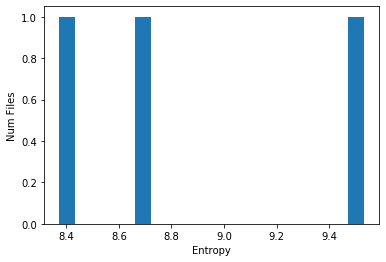

In [ ]:
# Create a histogram of the entropy distribution
plt.hist(LIB_corpus_entropies, bins = 20)
plt.ylabel("Num Files")
plt.xlabel("Entropy")
plt.show()

# Albergate as running example

In [ ]:
path = Path('../benchmarking/data/traceability/raw/Albergate_semeru_format'); path

PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format')

In [ ]:
system_name = "albergate"

In [ ]:
req_fns = sorted((path/'requirements').glob("*.txt"))
src_fns = sorted((path/'source_code').glob("*.java"))
req_fns[:5], src_fns[:5]

([PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-01.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-02.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-03.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-04.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-PRE-01.txt')],
 [PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AggiungiBeneServizio.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AggiungiSoggiornante.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AskChiudiConto.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AskChiudiSingoloConAgenzia.java'),
  PosixPath('..

In [ ]:
output = Path('/tf/data/')
all_fns = ",".join(map(str, req_fns + src_fns))

This BPE model should really be trained across all of the traceability systems when performing the re

In [ ]:
sp.SentencePieceTrainer.train(f'--input={all_fns} --model_prefix={output / system_name} --hard_vocab_limit=false')

True

In [ ]:
spm = sp.SentencePieceProcessor()
spm.Load(f"{output / system_name}.model")

True

In [ ]:
spm.EncodeAsPieces("this is a test, public static void main")

['▁this',
 '▁i',
 's',
 '▁a',
 '▁',
 'tes',
 't',
 ',',
 '▁pu',
 'blic',
 '▁sta',
 'tic',
 '▁vo',
 'id',
 '▁ma',
 'in']

## Get countings

In [ ]:
def get_docs(fns, spm):
    docs = []
    for fn in fns:
        with open(fn, encoding="ISO-8859-1") as f:
            docs.append(spm.EncodeAsPieces(f.read()))
    
    return docs

In [ ]:
def get_counters(docs):
    doc_cnts = []
    for doc in docs:
        cnt = Counter()
        for tok in doc:
            cnt[tok] += 1
            
        doc_cnts.append(cnt)
            
    return doc_cnts

In [ ]:
req_docs = get_docs(req_fns, spm)
src_docs = get_docs(src_fns, spm)

In [ ]:
req_cnts = get_counters(req_docs)
src_cnts = get_counters(src_docs)

In [ ]:
req_cnts[0].most_common(10)

[(':', 13),
 ('▁', 13),
 ('.', 11),
 ('i', 7),
 ('▁di', 7),
 ("'", 6),
 ('▁stanza', 6),
 ('à', 6),
 ('▁F', 5),
 ('▁o', 5)]

In [ ]:
src_cnt[0].most_common(10)

[('▁', 161),
 ('_', 137),
 ('.', 110),
 ('(', 105),
 (',', 83),
 (');', 82),
 ('onstrain', 48),
 ('▁=', 46),
 (')', 44),
 ('▁1,', 40)]

In [ ]:
len(req_cnts), len(src_cnts)

(17, 55)

## Generate a distribution from list of frequencies

In [ ]:
def get_dist(cnt):
    sz = sum(cnt.values())
    max_len = len(max(list(cnt), key=len))
    alphabet = []
    ps = []
    for tok in cnt:
        alphabet.append(tok)
        ps.append(cnt[tok] / sz)
    
    return dit.ScalarDistribution(alphabet, ps)

## _Shared_ Self-Information

This is **NOT** Mutual Information, this is the amount of self information contains in the shared tokens of the two corpora.

In [ ]:
def shared_entropy(x_cnt, y_cnt):
    overlap = list(set(x_cnt) & set(y_cnt))
    z_cnt = Counter({k: (x_cnt + y_cnt).get(k, 0) for k in overlap})
    
    return dit.shannon.entropy(get_dist(z_cnt))

In [ ]:
shared_entropy(full_req_cnt, full_src_cnt)

6.045348529909803

# SCRAP CODE

In [ ]:
req_set = set(req_cnt)
src_set = set(src_cnt)

In [ ]:
z = req_set.intersection(src_set)

In [ ]:
len(z)

535

In [ ]:
sz = sum(req_cnt.values())

In [ ]:
sz

6617

In [ ]:
set_docs = [set(doc) for doc in req_docs]

In [ ]:
alphabets = []
for doc in zip(*set_docs):
    alphabets.append(doc)

In [ ]:
alphabets = []
ps = []
for tok in req_cnt:
    ps.append(req_cnt[tok] / sz)

In [ ]:
sum(ps)

0.999999999999995

In [ ]:
alphabets

[('it',
  'it',
  'it',
  '▁supplemento',
  '▁due',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  '▁telefonica',
  '▁supplemento',
  'it',
  'it'),
 ('a',
  'a',
  'a',
  'it',
  'it',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'it',
  'it',
  'a',
  'a'),
 ('▁collegat',
  '▁collegat',
  '▁collegat',
  'a',
  'a',
  '▁collegat',
  '▁collegat',
  '▁considerat',
  '▁collegat',
  '▁collegat',
  '▁ristorante',
  '▁rend',
  'tabili',
  'a',
  'a',
  '▁collegat',
  '8'),
 ('atore',
  'metter',
  'atore',
  '▁collegat',
  '▁collegat',
  'ua',
  'atore',
  '▁collegat',
  'atore',
  'ua',
  '▁scelta',
  'ì',
  '▁collegat',
  '▁collegat',
  '▁collegat',
  '▁tel',
  '▁collegat'),
 ('▁stanza',
  '▁nel',
  '▁stanza',
  'volger',
  'ua',
  'atore',
  '▁stanza',
  'ua',
  '▁stanza',
  '▁nel',
  '▁collegat',
  '▁collegat',
  '▁stanza',
  'atore',
  '▁stanza',
  '▁l',
  'ua'),
 ('▁base',
  '▁dispos',
  '▁base',
  '▁stanza',
  'atore',
  '▁stanza',
  '▁viene',
  'atore

In [ ]:
d = dit.ScalarDistribution(set_docs, ps)

InvalidDistribution: Unequal lengths for `pmf` and `outcomes`

In [ ]:
dit.shannon.entropy(d)

8.25790699335952

In [ ]:
alphabet = []
ps = []
for tok in req_cnt:
    alphabet.append((tok,))
    ps.append(req_cnt[tok] / sz)

In [ ]:
print(alphabet)

[('▁Requisito',), ('▁numero',), (':',), ('▁F',), ('-',), ('G',), ('ES',), ('-01',), ('▁Tipo',), ('unzional',), ('e',), ('▁',), ('Gestione',), ('▁de',), ('i',), ('▁prezz',), ('▁delle',), ('▁camere',), ('.',), ('Descrizione',), ('Per',), ('▁o',), ('gni',), ('▁camera',), ('▁deve',), ('▁essere',), ('▁possibile',), ('▁stabili',), ('re',), ('▁il',), ('▁suo',), ('▁prezzo',), ('▁base',), ('Q',), ('uesto',), ('▁imposta',), ('bile',), ('▁dal',), ('▁gestore',), ('▁dell',), ("'",), ('albergo',), ('▁qual',), ('volta',), ('egli',), ('▁lo',), ('▁ri',), ('tenga',), ('▁opportuno',), ('▁Se',), ('▁si',), ('▁desidera',), ('▁modificare',), ('▁di',), ('▁una',), ('▁stanza',), ('▁che',), ('▁in',), ('▁quel',), ('▁momento',), ('▁risulta',), ('▁occupata',), (',',), ('▁sistema',), ('▁dovr',), ('à',), ('▁avvisa',), ('▁l',), ('oper',), ('atore',), ('▁con',), ('▁un',), ('▁messaggio',), ('▁per',), ('▁evi',), ('tare',), ('▁cliente',), ('▁la',), ('menti',), ('▁non',), ('▁aver',), ('pagato',), ('▁quanto',), ('▁pa',), ('

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
dit.shannon.entropy(d)

8.25790699335952

In [ ]:
def get_dist(cnt):
    sz = sum(cnt.values())
    max_len = len(max(list(cnt), key=len))
    alphabet = []
    ps = []
    for tok in cnt:
        alphabet.append((tok,))
        ps.append(cnt[tok] / sz)
    
    return dit.Distribution(alphabet, ps)

In [ ]:
dit.Distribution?

In [ ]:
dit.shannon.entropy(get_dist(req_cnt))

8.25790699335952

In [ ]:
dit.shannon.entropy(get_dist(src_cnt))

8.005993952354078

In [ ]:
all_cnt = req_cnt + src_cnt

In [ ]:
all_cnt.most_common(10)

[('▁', 5135),
 ('.', 5059),
 ('(', 3461),
 (');', 3018),
 (',', 2454),
 ('_', 2107),
 ('onstrain', 1671),
 ('▁=', 1664),
 ('▁{', 1438),
 ('▁}', 1438)]

In [ ]:
list(map(lambda x: (x,), list(req_toks)))

[('▁Requisito',),
 ('▁numero',),
 (':',),
 ('▁F',),
 ('-',),
 ('G',),
 ('ES',),
 ('-01',),
 ('▁Tipo',),
 (':',),
 ('▁F',),
 ('unzional',),
 ('e',),
 ('▁Requisito',),
 (':',),
 ('▁',),
 ('Gestione',),
 ('▁de',),
 ('i',),
 ('▁prezz',),
 ('i',),
 ('▁delle',),
 ('▁camere',),
 ('.',),
 ('▁',),
 ('Descrizione',),
 (':',),
 ('▁',),
 ('Per',),
 ('▁o',),
 ('gni',),
 ('▁camera',),
 ('▁deve',),
 ('▁essere',),
 ('▁possibile',),
 ('▁stabili',),
 ('re',),
 ('▁il',),
 ('▁suo',),
 ('▁prezzo',),
 ('▁base',),
 ('.',),
 ('▁',),
 ('Q',),
 ('uesto',),
 ('▁prezzo',),
 ('▁deve',),
 ('▁essere',),
 ('▁imposta',),
 ('bile',),
 ('▁dal',),
 ('▁gestore',),
 ('▁dell',),
 ("'",),
 ('albergo',),
 ('▁o',),
 ('gni',),
 ('▁qual',),
 ('▁',),
 ('volta',),
 ('▁',),
 ('egli',),
 ('▁lo',),
 ('▁ri',),
 ('tenga',),
 ('▁opportuno',),
 ('.',),
 ('▁Se',),
 ('▁si',),
 ('▁desidera',),
 ('▁modificare',),
 ('▁il',),
 ('▁prezzo',),
 ('▁base',),
 ('▁di',),
 ('▁una',),
 ('▁stanza',),
 ('▁che',),
 ('▁in',),
 ('▁quel',),
 ('▁momento',),
 

In [ ]:
dit.shannon.mutual_information(get_dist(all_cnt), list(map(lambda x: (x,), list(req_cnt))), list(map(lambda x: (x,), list(src_cnt))))

ditException: `rvs` contains invalid random variables, [('▁Requisito',), ('▁numero',), (':',), ('▁F',), ('-',), ('G',), ('ES',), ('-01',), ('▁Tipo',), ('unzional',), ('e',), ('▁',), ('Gestione',), ('▁de',), ('i',), ('▁prezz',), ('▁delle',), ('▁camere',), ('.',), ('Descrizione',), ('Per',), ('▁o',), ('gni',), ('▁camera',), ('▁deve',), ('▁essere',), ('▁possibile',), ('▁stabili',), ('re',), ('▁il',), ('▁suo',), ('▁prezzo',), ('▁base',), ('Q',), ('uesto',), ('▁imposta',), ('bile',), ('▁dal',), ('▁gestore',), ('▁dell',), ("'",), ('albergo',), ('▁qual',), ('volta',), ('egli',), ('▁lo',), ('▁ri',), ('tenga',), ('▁opportuno',), ('▁Se',), ('▁si',), ('▁desidera',), ('▁modificare',), ('▁di',), ('▁una',), ('▁stanza',), ('▁che',), ('▁in',), ('▁quel',), ('▁momento',), ('▁risulta',), ('▁occupata',), (',',), ('▁sistema',), ('▁dovr',), ('à',), ('▁avvisa',), ('▁l',), ('oper',), ('atore',), ('▁con',), ('▁un',), ('▁messaggio',), ('▁per',), ('▁evi',), ('tare',), ('▁cliente',), ('▁la',), ('menti',), ('▁non',), ('▁aver',), ('pagato',), ('▁quanto',), ('▁pa',), ('t',), ('ui',), ('to',), ('Input',), ('▁richiesto',), ('▁Si',), ('▁inseri',), ('identi',), ('ficato',), ('▁e',), ('▁ad',), ('▁essa',), ('▁relativo',), ('Output',), ('▁desiderat',), ('o',), ('▁Conferma',), ('▁a',), ('▁video',), ('▁della',), ('▁modifica',), ('▁avve',), ('n',), ('uta',), ('▁eventuali',), ('▁messaggi',), ('▁errore',), ('▁Cr',), ('terio',), ('▁accetta',), ('zione',), ('▁poter',), ('▁acce',), ('dere',), ('▁alla',), ('▁del',), ('▁listino',), ('▁richi',), ('a',), ('mare',), ('▁attr',), ('ave',), ('rso',), ('▁identi',), ('▁(',), ('es',), (');',), ('▁se',), ('▁richiest',), ('▁esiste',), ('▁visualizzat',), ('d',), ('errore',), ('▁sta',), ('▁fac',), ('end',), ('operazione',), ('▁rischi',), ('s',), ('▁A',), ('spetta',), ('ive',), ('▁collegat',), ('Sup',), ('ervi',), ('sione',), ('▁gestione',), ('▁stanze',), ('▁Requisit',), ('SO',), ('-04',), ('-05',), ('▁Sta',), ('▁Re',), ('le',), ('ase',), ('▁Pri',), ('ori',), ('▁Stabil',), ('it',), ('▁L',), ('llo',), ('▁compren',), ('C',), ('ategoria',), ('inale',), ('▁2',), ('Richiest',), ('▁P',), ('ien',), ('▁S',), ('oftware',), ('▁Ver',), ('▁2.',), ('1',), ('▁Data',), ('▁0',), ('4',), ('/04/',), ('1998',), ('▁Comp',), ('il',), ('ato',), ('▁da',), ('▁Ma',), ('rt',), ('ini',), ('▁R',), ('ob',), ('erto',), ('▁Not',), ('-02',), ('▁servizi',), ('▁spes',), ('▁extra',), ('▁Il',), ('metter',), ('▁dispos',), ('izione',), ('utente',), ('▁le',), ('▁f',), ('▁necessari',), ('▁D',), ('ovr',), ('▁qu',), ('indi',), ('▁visualizzare',), ('▁apportare',), ('▁modifiche',), ('▁nuove',), ('▁voci',), ('r',), ('▁an',), ('che',), ('▁prevista',), ('▁camp',), ('▁"',), ('j',), ('oll',), ('y',), ('"',), ('▁gesti',), ('ra',), ('è',), ('ven',), ('iente',), ('▁prevede',), ('▁specifica',), ('Dati',), ('▁bene',), ('▁servizio',), ('▁int',), ('▁effettuat',), ('▁complet',), ('▁codice',), ('▁c',), ('▁ritorn',), ('er',), ('▁nel',), ('▁cas',), ('▁nessuna',), ('▁corrispondenza',), ('▁sia',), ('▁verificat',), ('▁altri',), ('▁rest',), ('uir',), ('▁i',), ('▁dati',), ('▁relativ',), ('▁al',), ('▁possibil',), ('▁modificar',), ('ne',), ('▁offert',), ('2',), ('▁V',), ('inc',), ('enti',), ('▁Pa',), ('ola',), ('-03',), ('▁archivio',), ('▁storico',), ('▁clienti',), ('▁tenere',), ('▁alcuni',), ('▁tutt',), ('anno',), ('uccessiv',), ('▁quell',), ('▁soggiorno',), ('▁gi',), ('present',), ('▁nell',), ('elenco',), ('▁dovranno',), ('▁aggiornati',), ('▁Nel',), ('l',), ('\x92',), ('archivio',), ('▁sa',), ('ranno',), ('▁inseriti',), ('▁nome',), ('▁cognome',), ('▁indirizzo',), ('ultim',), ('lui',), ('▁De',), ('ve',), ('ltre',), ('▁recuperare',), ('▁conten',), ('uti',), ('ch',), ('é',), ('alberg',), ('▁possa',), ('▁informazioni',), ('utili',), ('quals',), ('▁ne',), ('▁ab',), ('bia',), ('▁necessit',), ('▁I',), ('rit',), ('iene',), ('util',), ('alva',), ('▁verr',), ('▁pres',), ('▁dall',), ('Aggiornamento',), ('▁devo',), ('no',), ('▁dura',), ('▁almen',), ('▁fin',), ('▁fine',), ('▁seguente',), ('▁inserimento',), ('▁all',), ('ultimo',), ('oter',), ('▁man',), ('tenere',), ('▁cont',), ('atto',), ('▁pi',), ('ù',), ('▁rec',), ('▁pro',), ('m',), ('uove',), ('▁pub',), ('blic',), ('izzare',), ('▁stagione',), ('nn',), ('▁10',), ('▁M',), ('ene',), ('gh',), ('atte',), ('▁Configurazione',), ('▁op',), ('zioni',), ('▁Alcun',), ('▁parametri',), ('▁utilizza',), ('volger',), ('▁attiv',), ('▁stat',), ('▁realizza',), ('te',), ('ci',), ('ò',), ('▁configura',), ('▁alle',), ('▁esi',), ('genz',), ('c',), ('ura',), ('mente',), ('compar',), ('ire',), ('ono',), ('▁seguenti',), ('▁impost',), ('azioni',), ('▁date',), ('▁inizio',), ('▁vari',), ('▁stagionalit',), ('▁sconti',), ('▁riduzioni',), ('▁effettuare',), ('▁neonati',), ('▁bambini',), ('▁durata',), ('▁massim',), ('▁pu',), ('▁restar',), ('▁bloccata',), ('▁supplemento',), ('▁costo',), ('uno',), ('▁scatto',), ('▁telefonico',), ('▁configurazione',), ('▁riten',), ('ute',), ('▁opportun',), ('▁inf',), ('▁sull',), ('rea',), ('▁comp',), ('enza',), ('E',), ('▁viene',), ('▁previst',), ('conto',), ('tale',), ('▁apparir',), ('▁chi',), ('ar',), ('amente',), ('▁calcolo',), ('▁conto',), ('▁finale',), ('▁su',), ('▁stampa',), ('▁Permette',), ('▁maggiore',), ('ibilit',), ('PR',), ('▁So',), ('spes',), ('O',), ('pzion',), ('ale',), ('▁15',), ('▁Ricerca',), ('▁disponibili',), ('▁elenc',), ('are',), ('▁periodo',), ('▁vi',), ('▁esatta',), ('▁mostrat',), ('▁disponibilit',), ('▁mod',), ('▁grado',), ('▁fornir',), ('▁sug',), ('ger',), ('imento',), ('▁come',), ('▁sposta',), ('▁rid',), ('men',), ('sion',), ('▁permanenza',), ('▁Tal',), ('▁inter',), ('vall',), ('▁tempo',), ('pre',), ('sso',), ('▁giorni',), ('corr',), ('▁tra',), ('▁due',), ('▁Ad',), ('empi',), ('5/0',), ('7',), ('/1998',), ('▁1',), ('1/0',), ('▁im',), ('plica',), ('▁7',), ('▁liber',), ('azione',), ('▁giorno',), ('2/0',), ('▁m',), ('atti',), ('na',), ('▁partire',), ('▁res',), ('▁disponibile',), ('▁altre',), ('▁prenotazioni',), ('▁La',), ('▁ricerca',), ('▁vincol',), ('▁bloccate',), ('▁assegnate',), ('▁commissionate',), ('▁agenzie',), ('▁viaggi',), ('▁fornit',), ('agenzia',), ('▁prima',), ('▁co',), ('pri',), ('▁commissionament',), ('ua',), ('ndo',), ('▁permett',), ('▁alcun',), ('▁prenotazione',), ('▁potr',), ('Periodo',), ('▁scelto',), ('tab',), ('ella',), ('▁riassum',), ('▁Dat',), ('▁ritornare',), ('▁evidenz',), ('tramite',), ('▁agenzia',), ('ed',), ('▁eventual',), ('▁Pr',), ('on',), ('ta',), ('▁verifica',), ('4.',), ('0',), ('▁16/04/',), ('▁Prenotazione',), ('▁parte',), ('▁effettua',), ('iare',), ('▁veng',), ('▁ha',), ('b',), ('itu',), ('mi',), ('co',), ('▁assegna',), ('gli',), ('rtar',), ('▁stata',), ('▁assegnata',), ('È',), ('conosc',), ('ere',), ('▁poss',), ('▁soddisfa',), ('disponibilit',), ('▁letto',), ('▁aggiuntivo',), ('▁vis',), ('/',), (').',), ('▁In',), ('▁forniti',), ('▁stess',), ('vedi',), ('egistra',), ('▁blocca',), ('ggio',), ('mento',), (')',), ('▁accord',), ('▁Do',), ('po',), ('▁accettata',), ('▁sott',), ('tta',), ('questo',), ('▁qua',), ('ro',), ('▁g',), ('ener',), ('▁albergo',), ('mplic',), ('▁ovv',), ('ero',), ('▁ved',), ('▁commissionata',), ('▁min',), ('imo',), ('▁provveder',), ('acco',), ('gua',), ('▁allo',), ('rganizza',), ('vo',), ('▁fatt',), ('▁ma',), ('▁real',), ('▁arriv',), ('▁support',), ('▁occupate',), ('-06',), ('▁2.0',), ('▁3',), ('0/0',), ('3',), ('▁Da',), ('nzi',), ('▁Fr',), ('ance',), ('sca',), ('Not',), ('▁rim',), ('arr',), ('▁fissat',), ('▁Tra',), ('▁invia',), ('accia',), ('▁comprender',), ('▁tr',), ('oppo',), ('▁ci',), ('▁informa',), ('▁ritardo',), ('▁dov',), ('uto',), ('▁contratt',), ('empo',), ('▁opp',), ('ure',), ('▁soggiorna',), ('primo',), ('▁r',), ('innova',), ('ment',), ('secondo',), ('▁cancellare',), ('Un',), ('▁arriva',), ('▁caparra',), ('▁passa',), ('▁aggiornat',), ('anti',), ('passata',), (';',), ('▁avvis',), ('▁pagamento',), ('▁controll',), ('▁riman',), ('ga',), ('▁lu',), ('ngo',), ('ando',), ('▁far',), ('▁pote',), ('ziali',), ('nsione',), ('termin',), ('ati',), ('▁period',), ('ebb',), ('▁tal',), ('▁risult',), ('eranno',), ('▁que',), ('▁sol',), ('vent',), ('giung',), ('ntro',), ('▁data',), ('▁concordat',), ('st',), ('pu',), ('lazione',), ('commissionamento',), ('nformazioni',), ('data',), ('▁do',), ('▁considerat',), ('▁commissione',), ('▁verificar',), ('▁loro',), ('▁effettivo',), ('▁anc',), ('ora',), ('▁esse',), ('ino',), ('esce',), ('▁occupar',), ('▁Cancellazione',), ('▁dai',), ('▁disd',), ('▁era',), ('orneranno',), ('annulla',), ('etta',), ('▁precedente',), ('▁stabilit',), ('▁scadenza',), ('▁No',), ('min',), ('ativo',), ('▁lascia',), ('▁Modifica',), ('▁prenota',), ('▁elimina',), ('▁corrispond',), ('▁esistente',), ('▁conferma',), ('▁cancella',), ('▁coinvol',), ('▁cambiat',), ('▁contra',), ('rio',), ('▁annulla',), ('seguente',), ('▁aggiornamento',), ('▁inesistente',), ('osi',), ('1.',), ('Colo',), ('mb',), ('ari',), ('nd',), ('▁registrat',), ('atura',), ('lmente',), ('▁aggiorna',), ('▁nomi',), ('▁tipo',), ('▁vuo',), ('▁cerca',), ('Effettuat',), ('9',), ('RIS',), ('▁ristorante',), ('▁estern',), ('tabilit',), ('mmediat',), ('▁normale',), ('▁soggiornanti',), ('hotel',), ('port',), ('ate',), ('▁singol',), ('▁scelta',), ('▁men',), ('▁fiss',), ('ing',), ('▁consumate',), ('▁ricev',), ('▁consuma',), ('numero',), ('▁persone',), ('▁bevande',), ('alit',), ('▁Stampa',), ('equisito',), ('▁forni',), ('sce',), ('▁ristorazione',), ('attiv',), ('9/0',), ('lli',), ('ria',), ('rrivo',), ('All',), ('▁risal',), ('▁and',), ('▁occupare',), ('▁proced',), ('▁fo',), ('se',), ('▁b',), ('sito',), ('▁fa',), ('▁nuovo',), ('▁richied',), ('▁aggiunger',), ('loro',), ('▁occupan',), ('certa',), ('nto',), ('con',), ('p',), ('iti',), ('▁soggiorn',), ('▁persona',), ('li',), ('fa',), ('colta',), ('tivi',), ('ragazz',), ('▁soggiornano',), ('ulti',), ('▁pensionamento',), ('▁permette',), ('▁divers',), ('▁distingu',), ('▁rie',), ('nt',), ('▁categori',), ('▁rend',), ('applica',), ('▁cos',), ('ì',), ('▁utilizzate',), ('▁dato',), ('appe',), ('lla',), ('tivo',), ('▁occupanti',), ('chiesto',), ('▁ripet',), ('▁annullar',), ('la',), ('▁p',), ('ulter',), ('iore',), ('onosc',), ('oggi',), ('ano',), ('▁Addebito',), ('valuta',), ('addebitare',), ('▁sul',), ('▁addebitar',), ('lo',), ('h',), ('▁usufrui',), ('▁quantit',), ('▁consumato',), ('▁traccia',), ('▁spesa',), ('▁poi',), ('▁recupera',), ('mmon',), ('Con',), ('tabili',), ('zza',), ('ma',), ('tic',), ('stra',), ('ordin',), ('arie',), ('fficien',), ('za',), ('▁telefonica',), ('Vis',), ('▁norma',), ('tiva',), ('▁indi',), ('ente',), ('▁tener',), ('▁scatti',), ('inizio',), ('olt',), ('▁prop',), ('rie',), ('tario',), ('addebito',), ('▁totale',), ('▁telefonate',), ('▁central',), ('▁comun',), ('icare',), ('▁telefonata',), ('nte',), ('▁addebito',), ('per',), ('ibili',), ('▁controlla',), ('▁ric',), ('ava',), ('van',), ('aggio',), ('▁dispo',), ('▁quest',), ('98',), ('interfacc',), ('▁questa',), ('▁commissionato',), ('get',), ('mulat',), ('cola',), ('▁Calcolo',), ('▁comple',), ('ssivo',), ('▁Al',), ('▁telefoniche',), ('▁3.',), ('▁parzial',), ('▁vo',), ('ce',), ('▁so',), ('rain',), ('dic',), ('ata',), ('totali',), ('informazion',), ('inter',), ('▁pernottament',), ('▁compre',), ('▁4',), ('▁-',), ('unica',), ('▁separato',), ('▁gli',), ('▁mo',), ('▁lasciare',), ('▁anticip',), ('▁risp',), ('etto',), ('▁esclus',), ('versat',), ('dati',), ('consiste',), ('▁numeri',), ('▁visualizzazione',), ('▁accumulat',), ('debito',), ('▁forma',), ('N',), ('U',), ('M',), ('MM',), ('ersone',), ('#',), ('ti',), ('###',), ('▁Scatti',), ('▁tel',), ('▁PARZIALE',), ('#####',), ('▁Desc',), ('▁...',), ('--------------',), ('---------------',), ('TO',), ('TAL',), ('#######',), ('▁pernottamento',), ('▁riporta',), ('hi',), ('▁cambio',), ('▁desider',), ('▁costr',), ('sto',), ('▁cambiare',), ('▁stru',), ('▁affinch',), ('Numero',), ('▁nuova',), ('▁indic',), ('▁occupa',), ('▁status',), ('▁ac',), ('▁riferi',), ('▁precede',), ('nza',), ('▁cambia',), ('8',)], set() 0.

In [ ]:
req_sz = sum(req_cnt.values())
src_sz = sum(src_cnt.values())

In [ ]:
all_cnt = req_cnt + src_cnt
sz = sum(all_cnt.values())
alphabet = []
ps = []
for tok in all_cnt:
    alphabet.append((tok, tok))
    ps.append(all_cnt[tok] / sz)

In [ ]:
alphabet = []
ps = []
for req_tok, src_tok in req_cnt:
    alphabet.append((req_tok))
    ps.append((req_cnt[req_tok] / req_sz, src_cnt[src_tok] / src_sz))

In [ ]:
len(alphabet), len(ps)

(949, 2490)

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
req_alphabet = []
src_ps = []
for tok in req_cnt:
    alphabet.append((tok, "a"))
    src_ps.append(req_cnt[tok] / sz)

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
d.rvs

[[0], [1]]

In [ ]:
d.alphabet

(('!',
  '!=',
  '"',
  '")',
  '"+',
  '",',
  '","',
  '","",',
  '",1',
  '",2',
  '",3',
  '",4',
  '#',
  '###',
  '#####',
  '#######',
  '%',
  '&',
  "'",
  '\'"',
  '\':"',
  '(',
  '("',
  '(""',
  '("")',
  '(""))',
  '(""+',
  '("",',
  '("","","',
  '("",1',
  '("",2',
  '("",3',
  '("",4',
  '()',
  '())',
  '()))',
  '())))',
  '()));',
  '())*',
  '()),',
  '()).',
  '());',
  '()+',
  '()+"',
  '()+"."',
  '()+"."+',
  '()+1)',
  '(),',
  '();',
  '(0',
  '(10,',
  '(15,',
  '(25',
  '(350,',
  '(4,1)',
  ')',
  '))',
  ')))',
  ')));',
  '))+',
  ')).',
  '));',
  ')+"',
  ').',
  ');',
  '*',
  '***************',
  '+',
  '+"',
  '+".',
  '+(',
  '++',
  '+1',
  '+1))',
  ',',
  ',"',
  ',"","","',
  ',0,0,4,',
  ',0.0,0.0,5,',
  ',1.0,0.0,',
  ',1.0,1.0,',
  '-',
  '--',
  '--------------',
  '---------------',
  '-01',
  '-02',
  '-03',
  '-04',
  '-05',
  '-06',
  '-1)',
  '-1;',
  '-1]',
  '-1]+"',
  '->',
  '.',
  '/',
  '/04/',
  '/1998',
  '0',
  '0)',
  '0,',

In [ ]:
len(d.alphabet)

1

In [ ]:
d.rvs

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138]

In [ ]:
dit.shannon.mutual_information(d, [0], [1], rv_mode = 'indexes')

8.230229937133148

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_mgmnt.prep.i.ipynb.
Converted 01_exp.i.ipynb.
Converted 02_mgmnt.db.mongo.ipynb.
Converted 03_repr.i.ipynb.
Converted 04_mining.ir.model.ipynb.
Converted 05_mining.ir.i.ipynb.
Converted 06_benchmark.traceability.ipynb.
Converted 07_repr.roberta.train.ipynb.
Converted 08_exp.info.ipynb.
Converted 09_desc.stats.ipynb.
Converted 10_vis.ipynb.
Converted 11_mgmnt.prep.nltk.ipynb.
Converted 12_repr.roberta.eval.ipynb.
Converted 14_mgmnt.prep.bpe.ipynb.
Converted 15_desc.metrics.se.ipynb.
Converted 16_repr.word2vec.train.ipynb.
Converted 17_repr.doc2vec.train.ipynb.
Converted 18_repr.doc2vec.eval.ipynb.
Converted 19_repr.word2vec.eval.ipynb.
Converted 20_benchmark.codegen.ipynb.
Converted 21_inf.i.ipynb.
Converted 22_inf.bayesian.ipynb.
Converted 23_inf.causal.ipynb.
Converted aa_blog.example.ipynb.
Converted ab_templates.example.ipynb.
Converted ac_emp.eval.pp1.rq1.ipynb.
Converted ad_emp.eval.pp1.rq2.ipynb.
Converted ae_emp.eval.pp1.rq3.ipynb.
Converted af_emp.eval.pp1.rq4.ipyn